In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import requests
import zipfile

def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded file saved at {save_path}")

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped files to {extract_to}")
    os.remove(zip_path)
    print(f"Deleted zip file at {zip_path}")

def main():
    url = 'https://figshare.com/ndownloader/files/48018562'
    download_path = 'downloaded_file.zip'

    download_file(url, download_path)
    unzip_file(download_path, os.getcwd())

if __name__ == '__main__':
    main()

Downloaded file saved at downloaded_file.zip
Unzipped files to /content
Deleted zip file at downloaded_file.zip


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score
import json
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
def load_and_preprocess_image(full_path, target_size):
    print(f"Loading image: {full_path}")  # Print the full path
    img = load_img(full_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

In [ ]:
def get_data(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    X = np.array([load_and_preprocess_image(os.path.join(base_dir, path.replace("\\", "/")), image_size) for path in df['image_path'].values])
    y = df[class_columns].values
    return X, y, df

In [ ]:
train_excel_path = "/content/Dataset/training/training_data.xlsx"
val_excel_path = "/content/Dataset/validation/validation_data.xlsx"
base_dir = "/content/Dataset"
image_size = (32, 32)
batch_size = 4096
epochs = 10

In [ ]:
X_train, y_train, _ = get_data(train_excel_path, base_dir, image_size=image_size)
X_val, y_val, val_df = get_data(val_excel_path, base_dir, image_size=image_size)

Streaming output truncated to the last 5000 lines.
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_8999.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9006.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9008.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9009.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9011.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9014.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9016.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9017.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9019.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9025.jpg
Loading image: /content/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9026.jpg
Loading image: /content/Dataset/vali

In [ ]:
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weights_dict)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.2097 - loss: 13.0304 - val_accuracy: 0.3335 - val_loss: 8.2004
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step - accuracy: 0.4268 - loss: 4.8017 - val_accuracy: 0.5109 - val_loss: 4.5089
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 751ms/step - accuracy: 0.5374 - loss: 2.8920 - val_accuracy: 0.5604 - val_loss: 2.8566
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 754ms/step - accuracy: 0.6039 - loss: 1.8757 - val_accuracy: 0.5713 - val_loss: 2.3911
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - accuracy: 0.6276 - loss: 1.4420 - val_accuracy: 0.5916 - val_loss: 1.9902
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 764ms/step - accuracy: 0.6552 - loss: 1.1281 - val_accuracy: 0.6440 - val_loss: 1.7754
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 732ms/step - accuracy: 0.6964 - loss: 0.9313 - val_accuracy: 0.6526 - val_loss: 1.6063
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 778ms/step - accuracy: 0.7068 - loss: 0.8042 - val_accuracy

In [ ]:
model.save('model.keras')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import json
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score

def save_predictions_to_excel(image_paths, y_pred, output_path):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)


def calculate_specificity(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

def generate_metrics_report(y_true, y_pred):
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    auc_roc_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            auc_roc_scores[class_name] = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc_roc_scores[class_name] = 0.0

    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc

    specificity_scores = {}
    for i, class_name in enumerate(class_columns):
        specificity_scores[class_name] = calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int))  # Thresholding y_pred

    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity

    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            average_precision_scores[class_name] = auc(recall, precision)
        except ValueError:
            average_precision_scores[class_name] = 0.0

    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision

    sensitivity_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            sensitivity_scores[class_name] = recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            sensitivity_scores[class_name] = 0.0

    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity

    f1_scores = {}
    for i, class_name in enumerate(class_columns):
        try:
            f1_scores[class_name] = f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0)
        except ValueError:
            f1_scores[class_name] = 0.0

    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score
    balanced_accuracy_scores = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy_scores

    metrics_report_json = json.dumps(metrics_report, indent=4)
    return metrics_report_json


In [ ]:
y_val_pred = model.predict(X_val)
metrics_rep=generate_metrics_report(y_val,y_val_pred)
print(metrics_rep)

505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
{
    "Angioectasia": {
        "precision": 0.35014409221902015,
        "recall": 0.48893360160965793,
        "f1-score": 0.4080604534005038,
        "support": 497.0
    },
    "Bleeding": {
        "precision": 0.30348837209302326,
        "recall": 0.7270194986072424,
        "f1-score": 0.42821985233798193,
        "support": 359.0
    },
    "Erosion": {
        "precision": 0.3503184713375796,
        "recall": 0.14285714285714285,
        "f1-score": 0.2029520295202952,
        "support": 1155.0
    },
    "Erythema": {
        "precision": 0.11578112609040445,
        "recall": 0.49158249158249157,
        "f1-score": 0.18741976893453144,
        "support": 297.0
    },
    "Foreign Body": {
        "precision": 0.3728813559322034,
        "recall": 0.6470588235294118,
        "f1-score": 0.4731182795698925,
        "support": 340.0
    },
    "Lymphangiectasia": {
        "precision": 0.21125370187561698,
        "recall": 0.6239067

In [ ]:
output_val_predictions="validation_excel.xlsx"
save_predictions_to_excel(val_df['image_path'].values, y_val_pred, output_val_predictions)

In [ ]:
train_excel_path = '/content/Dataset/training/training_data.xlsx'
val_excel_path = '/content/Dataset/validation/validation_data.xlsx'
train_df = pd.read_excel(train_excel_path)
val_df = pd.read_excel(val_excel_path)

In [ ]:
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
class_columns_excl_normal = [col for col in class_columns if col != 'Normal']

<ipython-input-27-891092b6d11a>:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
<ipython-input-27-891092b6d11a>:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))


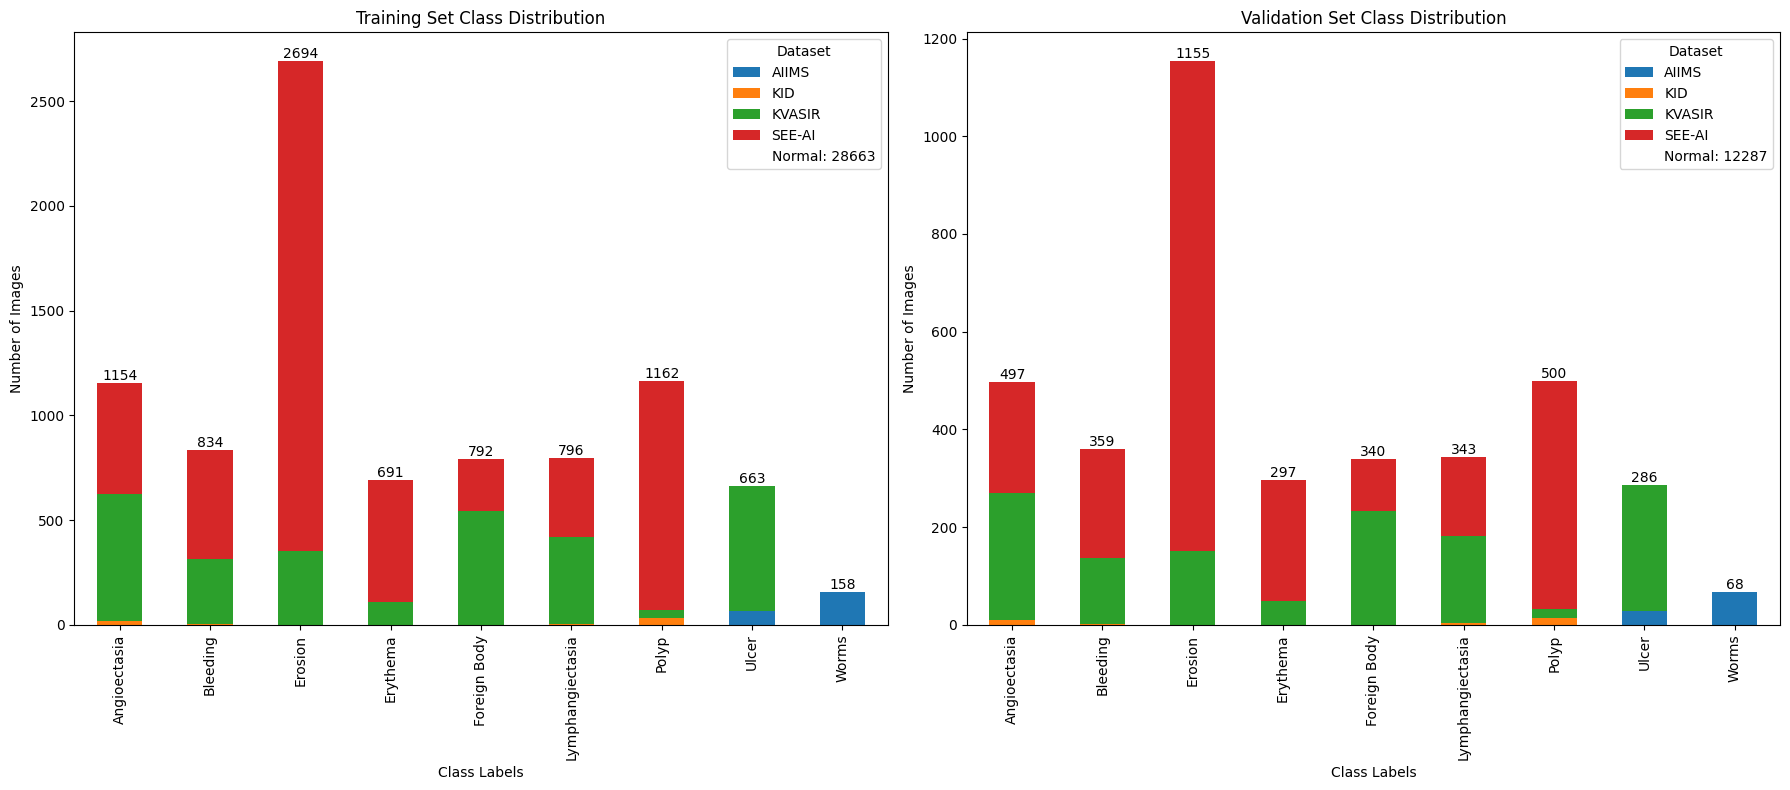

In [ ]:
import matplotlib.pyplot as plt  # ✅ Import Matplotlib
train_distribution_per_source = train_df.groupby('Dataset')[class_columns_excl_normal].sum().T
val_distribution_per_source = val_df.groupby('Dataset')[class_columns_excl_normal].sum().T
train_distribution = train_df[class_columns_excl_normal].sum()
val_distribution = val_df[class_columns_excl_normal].sum()

train_normal_count = train_df['Normal'].sum()
val_normal_count = val_df['Normal'].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

handles, labels = ax[0].get_legend_handles_labels()
handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
labels.append(f'Normal: {train_normal_count}')
ax[0].legend(handles, labels, title='Dataset')

val_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

handles, labels = ax[1].get_legend_handles_labels()
handles.append(plt.Rectangle((0,0),1,1, color='white', edgecolor='black'))
labels.append(f'Normal: {val_normal_count}')
ax[1].legend(handles, labels, title='Dataset')

plt.tight_layout()
plt.savefig('graph1.png')
plt.show()

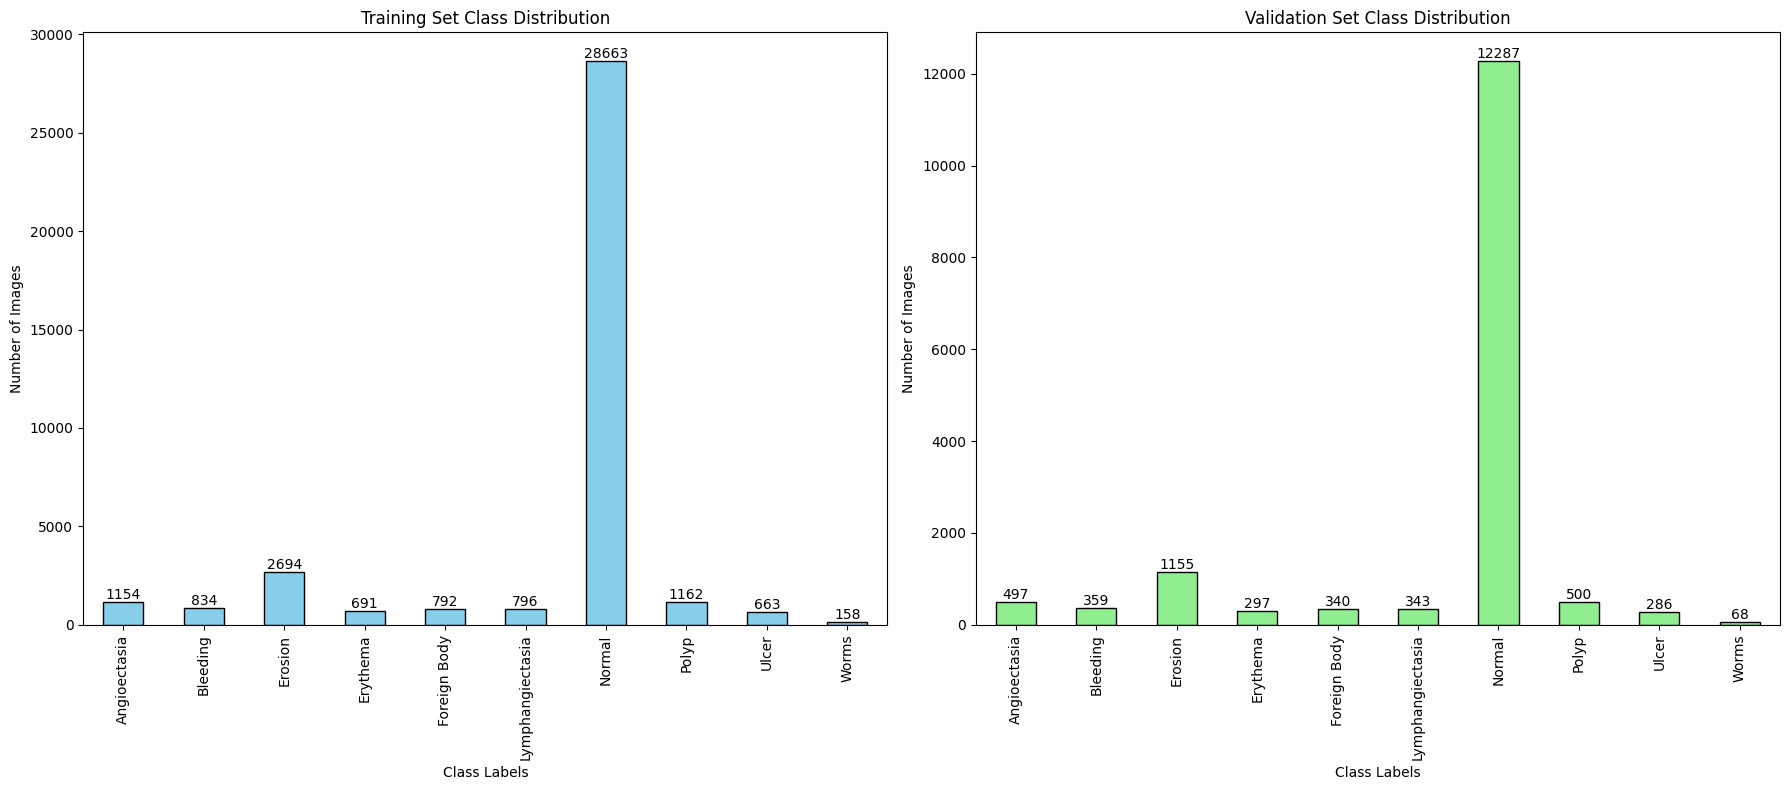

In [ ]:
train_distribution = train_df[class_columns].sum()
val_distribution = val_df[class_columns].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph2.png')
plt.show()

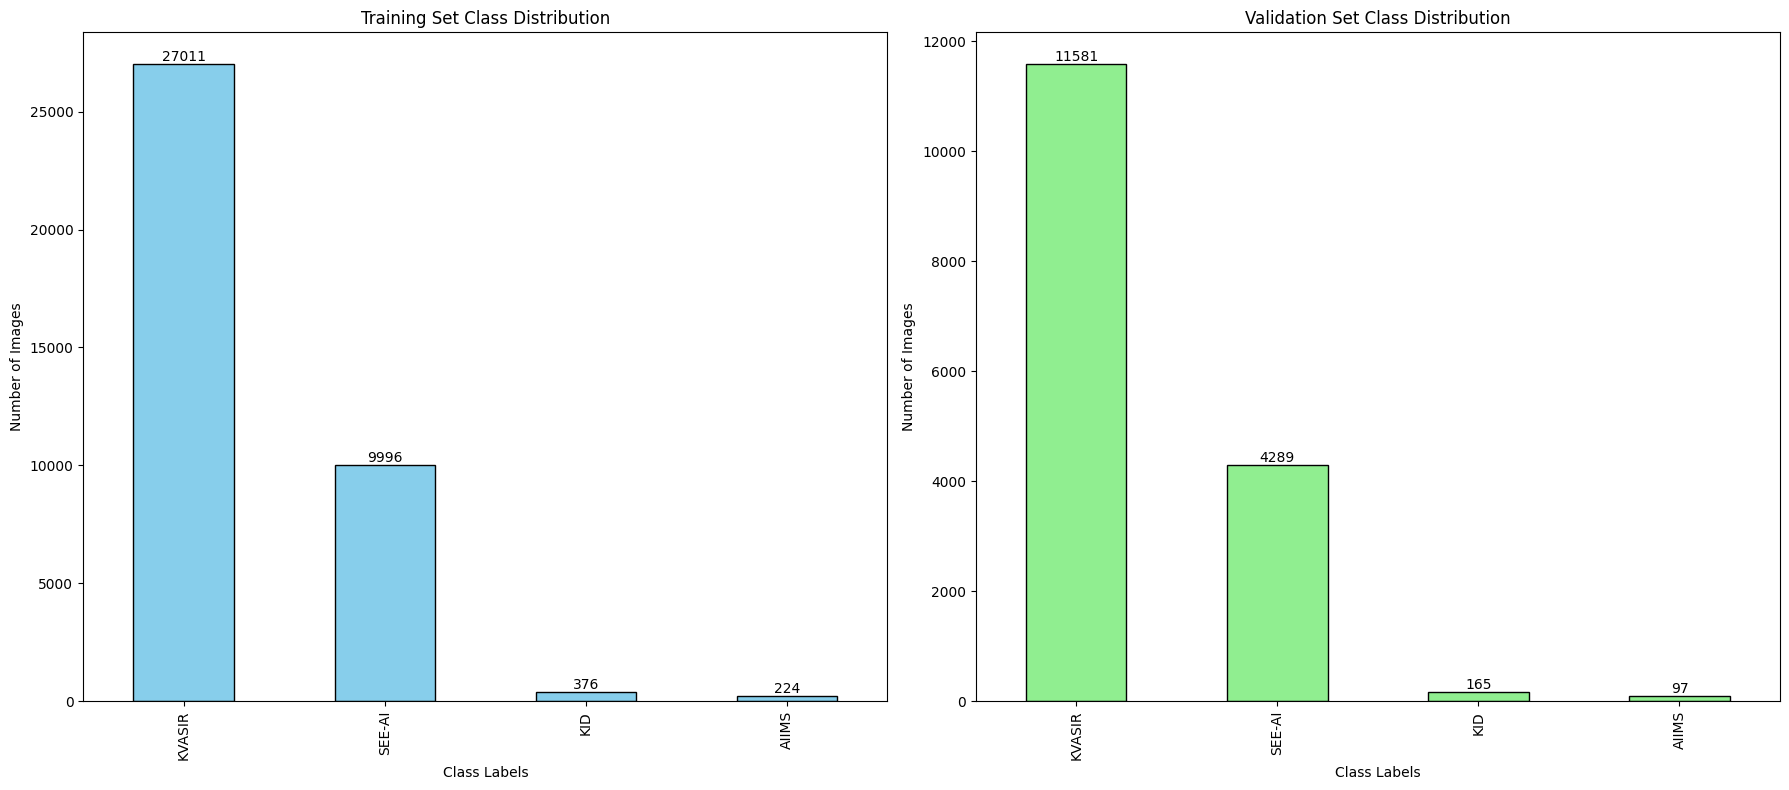

In [ ]:
train_df = train_df.dropna(subset=['image_path', 'Dataset'])
val_df = val_df.dropna(subset=['image_path', 'Dataset'])

train_distribution = train_df['Dataset'].value_counts()
val_distribution = val_df['Dataset'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph3.png')
plt.show()

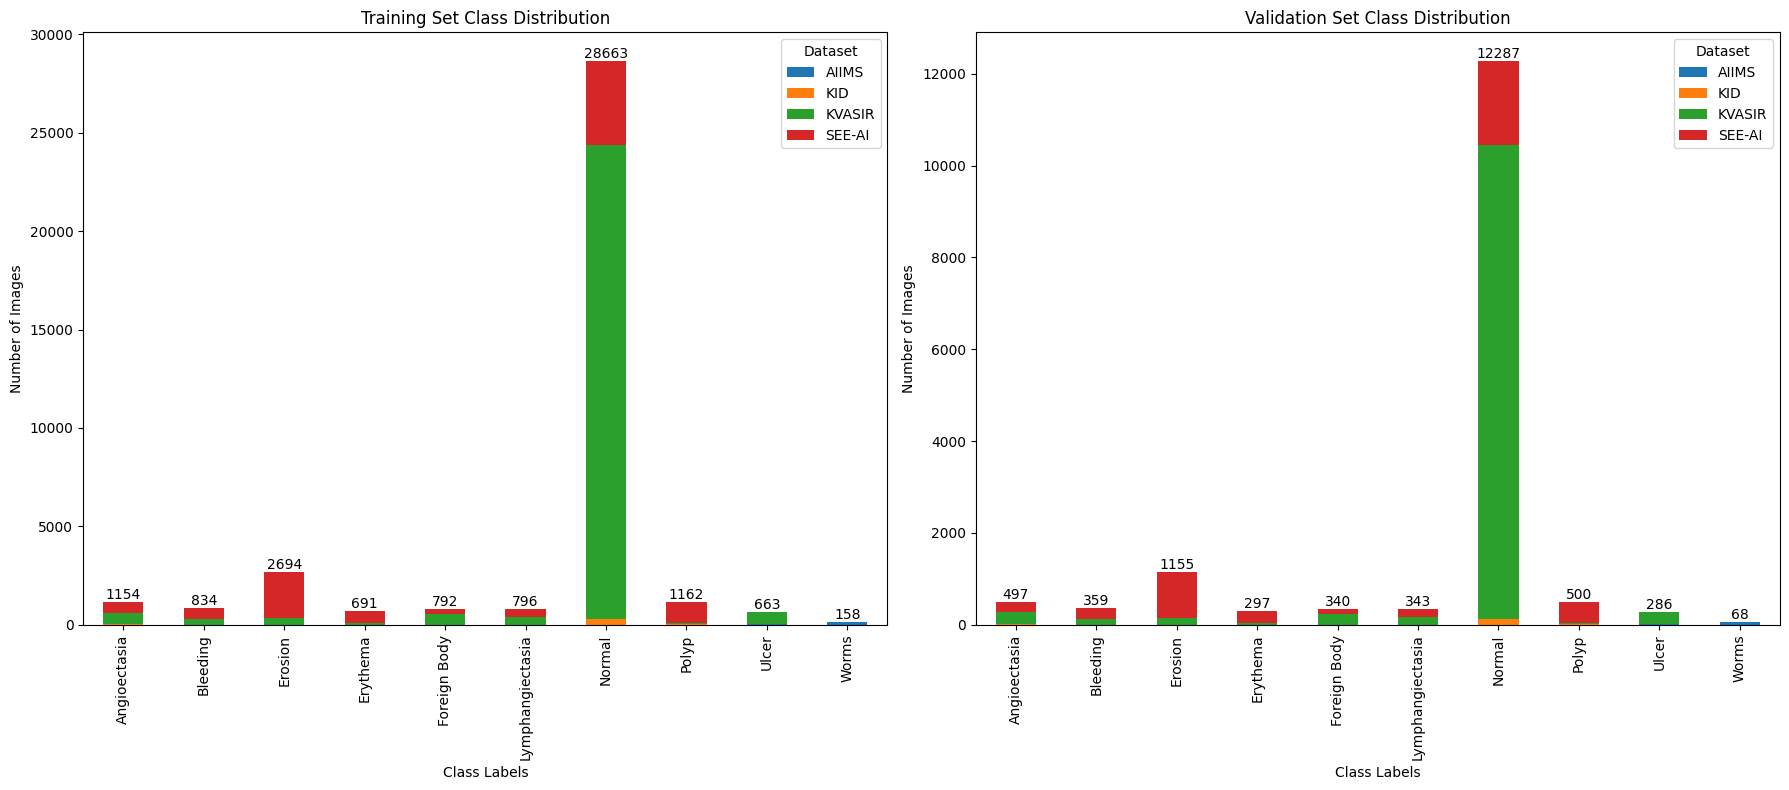

In [ ]:
train_df = pd.read_excel(train_excel_path)
val_df = pd.read_excel(val_excel_path)
train_distribution_per_source = train_df.groupby('Dataset')[class_columns].sum().T
val_distribution_per_source = val_df.groupby('Dataset')[class_columns].sum().T
train_distribution = train_df[class_columns].sum()
val_distribution = val_df[class_columns].sum()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class Labels')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_distribution_per_source.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class Labels')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph4.png')
plt.show()

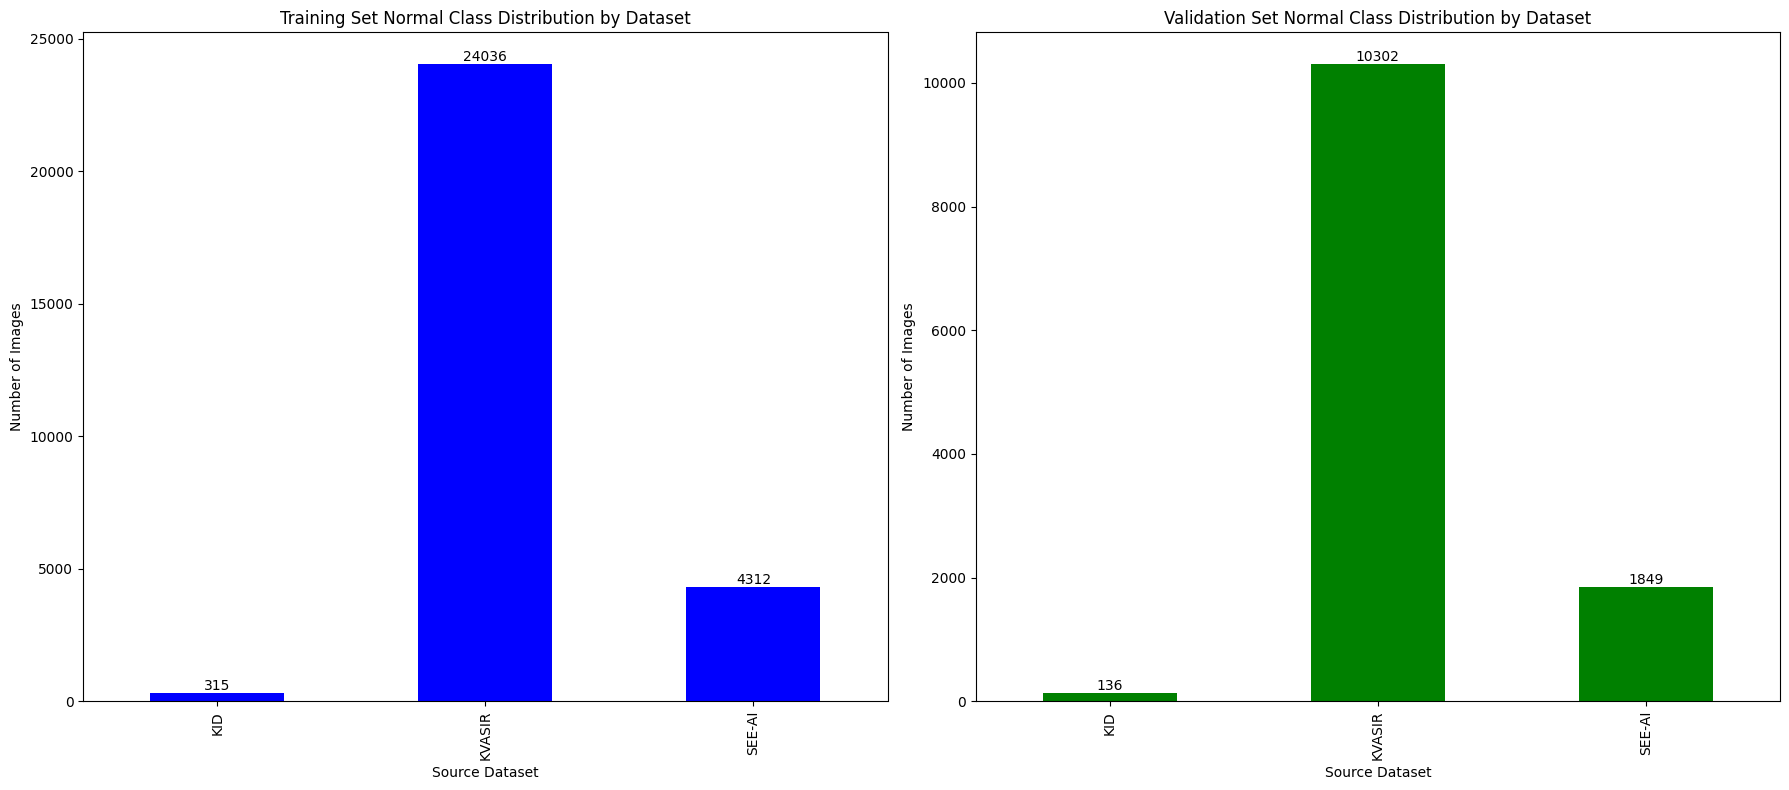

In [ ]:
train_normal_df = train_df[train_df['Normal'] == 1]
val_normal_df = val_df[val_df['Normal'] == 1]

train_normal_distribution = train_normal_df.groupby('Dataset')['Normal'].count()
val_normal_distribution = val_normal_df.groupby('Dataset')['Normal'].count()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

train_normal_distribution.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Training Set Normal Class Distribution by Dataset')
ax[0].set_xlabel('Source Dataset')
ax[0].set_ylabel('Number of Images')
for index, value in enumerate(train_normal_distribution):
    ax[0].text(index, value, str(value), ha='center', va='bottom')

val_normal_distribution.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Validation Set Normal Class Distribution by Dataset')
ax[1].set_xlabel('Source Dataset')
ax[1].set_ylabel('Number of Images')
for index, value in enumerate(val_normal_distribution):
    ax[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('graph5.png')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("model.keras")
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
import os
import json

# ✅ Define dataset path
train_dir = "/content/Dataset/training"  # Update if needed

# ✅ Get disease class names
disease_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# ✅ Create class index mapping
class_indices = {disease: idx for idx, disease in enumerate(disease_classes)}

# ✅ Save to JSON
json_path = "/content/class_indices.json"
with open(json_path, "w") as f:
    json.dump(class_indices, f, indent=4)

print(f"✅ class_indices.json saved at {json_path}")
print(json.dumps(class_indices, indent=4))  # Display the JSON mapping


✅ class_indices.json saved at /content/class_indices.json
{
    "Angioectasia": 0,
    "Bleeding": 1,
    "Erosion": 2,
    "Erythema": 3,
    "Foreign Body": 4,
    "Lymphangiectasia": 5,
    "Normal": 6,
    "Polyp": 7,
    "Ulcer": 8,
    "Worms": 9
}


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import json

# Load class indices (saved earlier)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

def predict_disease(image_path, model, target_size=(32, 32)): # Change target_size to (32, 32)
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Get class index
    predicted_label = class_labels[predicted_class]  # Get disease name

    return predicted_label, predictions

# Example: Predict disease for a new image


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Disease: Polyp
Confidence Scores: [[6.2098703e-04 3.6172250e-01 1.8981439e-01 6.0546739e-05 5.5300711e-09
  1.5967931e-03 1.0608442e-02 4.3428648e-01 1.2897952e-03 4.2842465e-19]]


In [ ]:
image_path = "/content/Dataset/validation/Erosion/KVASIR/0531325b64674948_248.jpg"  # Change to your test image
predicted_disease, confidence_scores = predict_disease(image_path, model)

print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Scores: {confidence_scores}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Disease: Erosion
Confidence Scores: [[1.4122787e-02 1.7212453e-01 3.8515610e-01 2.9759362e-02 6.8297766e-02
  2.4409378e-03 3.0199984e-01 2.1501822e-02 4.5969523e-03 2.6382939e-17]]
